# Dataset Selection and Information

I chose to work with the **Human Activity Recognition Using Smartphones dataset** from the UCI Machine Learning Repository.

- **Dataset link**: [https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones)
- **Instances**: 10,299
- **Features**: 561 time-series features from accelerometer and gyroscope signals
- **Target**: Multiclass classification (6 activities)
  - `WALKING`
  - `WALKING_UPSTAIRS`
  - `WALKING_DOWNSTAIRS`
  - `SITTING`
  - `STANDING`
  - `LAYING`

## Why Sequence Models?

This dataset contains time-series sensor data collected from smartphones worn by individuals while performing various activites of daily living (ADL's). The temporal relationship between the readings is how we decide on the activity being performed. For example, distinguishing between "walking" and "walking upstairs" depends on how signal patterns relate to eachother over time, not just on individual measurements. Therefore, a sequence model is apropriate for this challenge.

## Chosen Framework

For this task, I will use PyTorch because it provides support for building and training sequence models with `nn.LSTM` and `nn.GRU` (see reference [1], see reference [2])



# Data Visualization and Pre-processing

The dataset comes pre-processed and conviniently structured (see reference [3]):

- Sensor signals (accelerometer and gyroscope) have already been filtered to remove noise.
- The signals are segmented into fixed width sliding windows of 2.56 seconds with 50% overlap, resulting in 128 time steps per sample.
- From each window, 561 features have been extracted based on both time and frequency domain signals (mean, standard deviation, FFT-based features).
- All features are normalized and bounded within `[-1, 1]`

The dataset is already split into:
- Training set: `train/X_train.txt`, `train/y_train.txt`, `train/subject_train.txt`
- Test set: `test/X_test.txt`, `test/y_test.txt`, `test/subject_test.txt`

## Remaining Preprocessing Tasks

We will still need to:

- Convert labels into OHE format for use in classification models (see reference [4]).
- Reshape input data to fit the expected format of PyTorch RNN layers (batch_size, sequence_length, input_size).
- Visualize class distribution to check for class imbalance.
- Create a validation set from the training data (80/20) to evaluate during training.


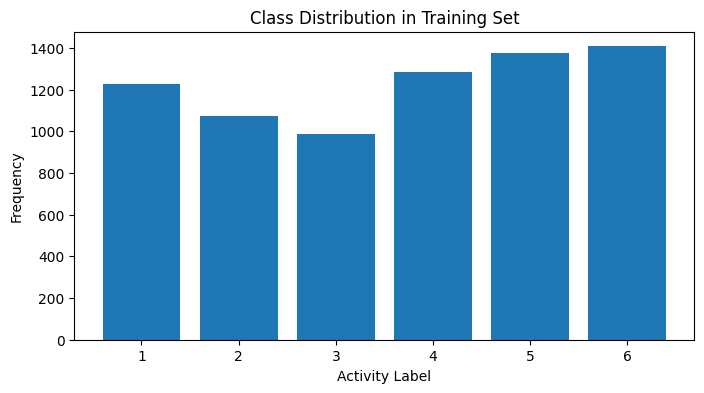

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Load the data
X_train = np.loadtxt('../data/train/X_train.txt')
y_train = np.loadtxt('../data/train/y_train.txt').astype(int)
X_test = np.loadtxt('../data/test/X_test.txt')
y_test = np.loadtxt('../data/test/y_test.txt').astype(int)

# Convert labels to OHE (see reference [4])
encoder = OneHotEncoder(sparse_output=False)
y_train_oh = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_oh = encoder.transform(y_test.reshape(-1, 1))

# Reshape input data for PyTorch
# Original shape is (n_samples, 561)
# Each sample will treated as a sequence of 1 timestep with 561 features so we dont have to do more preprocessing on the data
X_train_rnn = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_rnn = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Visualize class distribution
unique, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(8, 4))
plt.bar(unique, counts, tick_label=[str(i) for i in unique])
plt.title('Class Distribution in Training Set')
plt.xlabel('Activity Label')
plt.ylabel('Frequency')
plt.show()

# Create validation set (80/20 split from training data)
X_train_rnn, X_val_rnn, y_train_oh, y_val_oh = train_test_split( X_train_rnn, y_train_oh, test_size=0.2, random_state=42, stratify=y_train)


## Class distribution

The class distribution appears to be fairly balanced. There should theoretically be no issues with the model prediciting entirely based on class distribution to minimize loss.

# RNN Implementation 

We will implement implement a the RNN using the `nn.RNN` module.

- Input size: 561
- Hidden size: 128
- Number of RNN layers: 1
- Output size: 6 (One for each classification)
- Activation function (hidden): `tanh` (this is default in `nn.RNN`)
- Activation function (output): `softmax` (this is done internaly with `CrossEntropyLoss`) (see refernce [6])
- Optimizer: Adam (As we found this to be most effective in out `bank-neural-net` testing)

## Evaluation Metric

The primary evaluation metric is f1 score on both the validation and test sets.

Epoch 1/15 - Loss: 66.3936 - F1: 0.8994
Epoch 2/15 - Loss: 23.5399 - F1: 0.9422
Epoch 3/15 - Loss: 15.9231 - F1: 0.9524
Epoch 4/15 - Loss: 13.0954 - F1: 0.9591
Epoch 5/15 - Loss: 9.9885 - F1: 0.9611
Epoch 6/15 - Loss: 8.5152 - F1: 0.9585
Epoch 7/15 - Loss: 7.8549 - F1: 0.9684
Epoch 8/15 - Loss: 6.1084 - F1: 0.9755
Epoch 9/15 - Loss: 5.8982 - F1: 0.9765
Epoch 10/15 - Loss: 5.4604 - F1: 0.9755
Epoch 11/15 - Loss: 5.7519 - F1: 0.9770
Epoch 12/15 - Loss: 5.0320 - F1: 0.9793
Epoch 13/15 - Loss: 4.5273 - F1: 0.9811
Epoch 14/15 - Loss: 4.4619 - F1: 0.9805
Epoch 15/15 - Loss: 3.9172 - F1: 0.9777


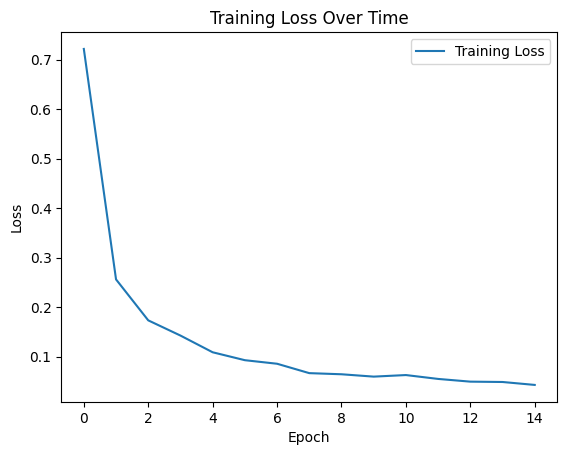

In [14]:
# imports 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score  

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train_rnn, dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train_oh, axis=1), dtype=torch.long)
X_val_tensor = torch.tensor(X_val_rnn, dtype=torch.float32)
y_val_tensor = torch.tensor(np.argmax(y_val_oh, axis=1), dtype=torch.long)
X_test_tensor = torch.tensor(X_test_rnn, dtype=torch.float32)
y_test_tensor = torch.tensor(np.argmax(y_test_oh, axis=1), dtype=torch.long)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

# Define RNN model (see reference [5])
class BasicRNN(nn.Module):
    def __init__(self, input_size=561, hidden_size=128, output_size=6):
        super(BasicRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x) 
        out = out[:, -1, :]   # Use last time step out for classification
        return self.fc(out)

# Initialize RNN Model
model = BasicRNN()
criterion = nn.CrossEntropyLoss()  # (see reference [6])
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
train_losses = []
val_f1_scores = []
epochs = 15

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    # Training
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # Validation
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.tolist())
            all_targets.extend(y_batch.tolist())

    # Compute F1 score for validation set (see reference [7])
    val_f1 = f1_score(all_targets, all_preds, average='macro')
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - F1: {val_f1:.4f}")

# Plot training loss
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()


## Testing

We will now evaluate the models preformance on the test set data.

In [20]:
# Evaluate on the test set using F1 score (see reference [7])
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():  # Disables gradient calculation
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)  # Forward pass
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        all_preds.extend(predicted.tolist())
        all_targets.extend(y_batch.tolist())

# Compute overall F1 score 
test_f1 = f1_score(all_targets, all_preds, average='macro')
print(f"RNN Test F1 Score: {test_f1:.4f}")


RNN Test F1 Score: 0.9461


## LSTM Implementation

In this implementation, we use `nn.LSTM` from PyTorch (see reference [1]) with the following:

- Input size: 561
- Hidden size: 128
- Number of layers: 1
- Output size: 6 
- Activation: Built in gates (input, forget, output), no manual activation needed
- Final layer: `CrossEntropyLoss` for classification (see reference [6])

## Evaluation Metric

We continue using macro-averaged F1 score (see reference [7]) to measure performance across all classes.

[LSTM] Epoch 1/15 - Loss: 64.0239 - F1: 0.8711
[LSTM] Epoch 2/15 - Loss: 22.1508 - F1: 0.9405
[LSTM] Epoch 3/15 - Loss: 14.5499 - F1: 0.9476
[LSTM] Epoch 4/15 - Loss: 10.2268 - F1: 0.9637
[LSTM] Epoch 5/15 - Loss: 8.5429 - F1: 0.9451
[LSTM] Epoch 6/15 - Loss: 7.1084 - F1: 0.9725
[LSTM] Epoch 7/15 - Loss: 6.6780 - F1: 0.9782
[LSTM] Epoch 8/15 - Loss: 6.3223 - F1: 0.9255
[LSTM] Epoch 9/15 - Loss: 5.2839 - F1: 0.9781
[LSTM] Epoch 10/15 - Loss: 4.7924 - F1: 0.9796
[LSTM] Epoch 11/15 - Loss: 5.0554 - F1: 0.9774
[LSTM] Epoch 12/15 - Loss: 4.5867 - F1: 0.9817
[LSTM] Epoch 13/15 - Loss: 4.1458 - F1: 0.9759
[LSTM] Epoch 14/15 - Loss: 4.3110 - F1: 0.9810
[LSTM] Epoch 15/15 - Loss: 4.6717 - F1: 0.9823


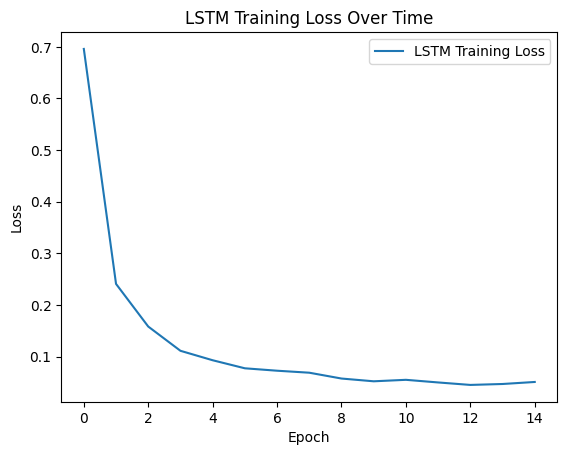

In [16]:
# Define LSTM model (see reference [1])
class LSTMClassifier(nn.Module):
    def __init__(self, input_size=561, hidden_size=128, output_size=6):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # Use last time step out for classification
        return self.fc(out)

# Initialize LSTM model
lstm_model = LSTMClassifier()
criterion = nn.CrossEntropyLoss()  # see reference [6]
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Training loop
lstm_train_losses = []
lstm_val_f1_scores = []
epochs = 15

for epoch in range(epochs):
    lstm_model.train()
    epoch_loss = 0

    # Training 
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits = lstm_model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    lstm_train_losses.append(epoch_loss / len(train_loader))

    # Validation
    lstm_model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = lstm_model(X_batch)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.tolist())
            all_targets.extend(y_batch.tolist())

    # Compute F1 score for validation set (see reference [7])
    val_f1 = f1_score(all_targets, all_preds, average='macro') 
    lstm_val_f1_scores.append(val_f1)

    print(f"[LSTM] Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - F1: {val_f1:.4f}")

# Plot loss
plt.plot(lstm_train_losses, label='LSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('LSTM Training Loss Over Time')
plt.legend()
plt.show()


## Testing

We will now evaluate the models preformance on the test set data.

In [17]:
# Evaluate LSTM on test set using macro F1 score
lstm_model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = lstm_model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.tolist())
        all_targets.extend(y_batch.tolist())

lstm_test_f1 = f1_score(all_targets, all_preds, average='macro')
print(f"LSTM Test F1 Score: {lstm_test_f1:.4f}")

LSTM Test F1 Score: 0.9513


## GRU Implementation

In this implementation, we use `nn.GRU` from PyTorch (see reference [2]) with the following:

- Input size: 561  
- Hidden size: 128  
- Number of layers: 1  
- Output size: 6  
- Activation: Built-in reset and update gates, no manual activation needed  
- Final layer: `CrossEntropyLoss` for classification (see reference [6])

## Evaluation Metric

We continue using macro-averaged F1 score (see reference [7]) to measure performance across all classes.


[GRU] Epoch 1/15 - Loss: 61.7325 - F1: 0.9190
[GRU] Epoch 2/15 - Loss: 21.8278 - F1: 0.9428
[GRU] Epoch 3/15 - Loss: 14.1906 - F1: 0.9543
[GRU] Epoch 4/15 - Loss: 11.0148 - F1: 0.9562
[GRU] Epoch 5/15 - Loss: 8.8704 - F1: 0.9688
[GRU] Epoch 6/15 - Loss: 7.7163 - F1: 0.9747
[GRU] Epoch 7/15 - Loss: 6.3150 - F1: 0.9772
[GRU] Epoch 8/15 - Loss: 6.6327 - F1: 0.9728
[GRU] Epoch 9/15 - Loss: 5.3657 - F1: 0.9786
[GRU] Epoch 10/15 - Loss: 5.8954 - F1: 0.9791
[GRU] Epoch 11/15 - Loss: 4.9607 - F1: 0.9808
[GRU] Epoch 12/15 - Loss: 4.4268 - F1: 0.9809
[GRU] Epoch 13/15 - Loss: 4.2213 - F1: 0.9806
[GRU] Epoch 14/15 - Loss: 3.9153 - F1: 0.9811
[GRU] Epoch 15/15 - Loss: 4.3541 - F1: 0.9789


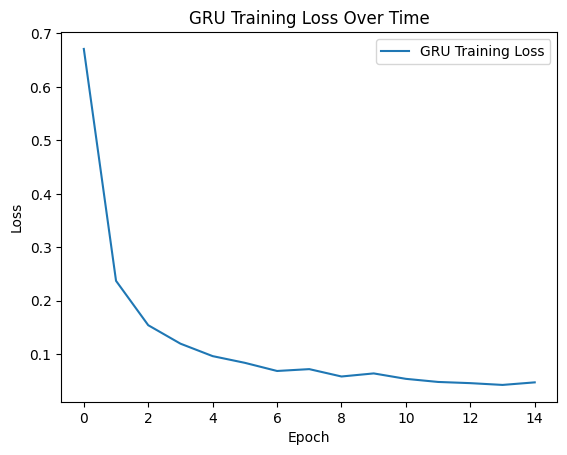

In [18]:
# Define GRU model (see reference [2])
class GRUClassifier(nn.Module):
    def __init__(self, input_size=561, hidden_size=128, output_size=6):
        super(GRUClassifier, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = out[:, -1, :]   # Use last time step out for classification
        return self.fc(out)

# Initialize GRU model
gru_model = GRUClassifier()
criterion = nn.CrossEntropyLoss()  # see reference [6]
optimizer = optim.Adam(gru_model.parameters(), lr=0.001)

# Training loop
gru_train_losses = []
gru_val_f1_scores = []
epochs = 15

for epoch in range(epochs):
    gru_model.train()
    epoch_loss = 0

    # Training 
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits = gru_model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    gru_train_losses.append(epoch_loss / len(train_loader))

    # Validation
    gru_model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            outputs = gru_model(X_batch)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.tolist())
            all_targets.extend(y_batch.tolist())

    # Compute F1 score for validation set (see reference [7])
    val_f1 = f1_score(all_targets, all_preds, average='macro')  
    gru_val_f1_scores.append(val_f1)

    print(f"[GRU] Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - F1: {val_f1:.4f}")

# Plot loss
plt.plot(gru_train_losses, label='GRU Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GRU Training Loss Over Time')
plt.legend()
plt.show()


## Testing

We will now evaluate the models preformance on the test set data.

In [19]:
# Evaluate GRU on test set using macro F1 score
gru_model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = gru_model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.tolist())
        all_targets.extend(y_batch.tolist())

gru_test_f1 = f1_score(all_targets, all_preds, average='macro')
print(f"GRU Test F1 Score: {gru_test_f1:.4f}")


GRU Test F1 Score: 0.9390


# Evaluation

The test F1 scores for each model are as follows:

- LSTM: 0.9513  
- GRU: 0.9390  
- Basic RNN: 0.9461  

The LSTM outperforms both GRU and the basic RNN(though by a very small margin). This is expected because LSTM networks are designed to handle longterm dependencies using gates that can help remember extra infromation between layers. The GRU, while slightly less accurate than LSTM, still did well, but it did perform worse then the basic RNN. The basic RNN performs surprisingly well but lacks the ability to consistently retain temporal information across long sequences. This challenge may be simple enough where using a LSTM/GRU may be unnecissary when compared to a basic RNN.

# Can a Feed-Forward Network Solve This Problem? (see reference [8])

A feed-forward neural network can be used if the time-series data is transformed into a flat feature vector. This can be done though feature engineering or by summarizing time-series statistics. The dataset that was chosen earlier provides 561 features from sliding windows which makes it compatible with a feed-forward network should that have been required.

This approach does still have limitations. A feed-forward network does not inherently model temporal dependencies or sequence order. Sequence models like RNN, LSTM, and GRU are designed to learn patterns across time steps. So while a feed-forward network may work and be a valid model, it is mby design less effective for capturing temporal patterns compared to recurrent models.


## References

1. PyTorch. (n.d.). *torch.nn.LSTM — PyTorch Documentation*.  
   Retrieved from https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html

2. PyTorch. (n.d.). *torch.nn.GRU — PyTorch Documentation*.  
   Retrieved from https://pytorch.org/docs/stable/generated/torch.nn.GRU.html

3. Anguita, D., Ghio, A., Oneto, L., Parra, X., & Reyes-Ortiz, J. L. (2013). *A Public Domain Dataset for Human Activity Recognition Using Smartphones*.  
   Retrieved from https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones

4. scikit-learn. (n.d.). *OneHotEncoder — scikit-learn 1.4.2 documentation*.  
   Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html

5. GeeksforGeeks. (n.d.). *Implementing Recurrent Neural Networks in PyTorch*.  
   Retrieved from https://www.geeksforgeeks.org/deep-learning/implementing-recurrent-neural-networks-in-pytorch/

6. PyTorch. (n.d.). *torch.nn.CrossEntropyLoss — PyTorch Documentation*.  
   Retrieved from https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

7. scikit-learn. (n.d.). *sklearn.metrics.f1_score — scikit-learn 1.4.2 documentation*.  
   Retrieved from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

8. GeeksforGeeks. (n.d.). *Feedforward Neural Network*.  
   Retrieved from https://www.geeksforgeeks.org/nlp/feedforward-neural-network/
